# Stable Diffusion Text to Image

<div dir="rtl" lang="he" xml:lang="he">

שם התלמיד: מאור קורנפלד

לינק לסרטון היישום:

<img src= https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-sdv1.5.png style="width:10px;height:10px;">



# Loading necessary libraries


In [ ]:
!pip install datasets xformers
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import accelerate
import transformers
import PIL
import os
import io
import torch
import torchvision
import torch.nn.functional as F
from torchsummary import summary
from PIL import Image
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, StableDiffusionPipeline, PNDMScheduler
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
from safetensors.torch import load_file, save_file
from torchvision import transforms
from tqdm.auto import tqdm
from accelerate import Accelerator
from accelerate.utils import set_seed

In [ ]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [ ]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The model components are taken from Hugging-Face:

https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5

In [ ]:
model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_safetensors=True).to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer", use_safetensors=True)
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", use_safetensors=True).to(device)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_safetensors=True).to(device)
scheduler = PNDMScheduler.from_pretrained(model_name, subfolder="scheduler")

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_weights = "fine_tuned-v1-5.safetensors"

In [ ]:
file_path = "/content/drive/MyDrive/SD FN project/v1-5-pruned.safetensors"
loaded = load_file(file_path)

In [ ]:
len(unet.state_dict().keys())

686

In [ ]:
len(loaded.keys())

1831

In [ ]:
# Create directory to save updated weights
output_dir = "fine_tuned_weights"
os.makedirs(output_dir, exist_ok=True)
output_dir

'fine_tuned_weights'

# Loading dataset and preprocessing

the dataset is taken from:

https://huggingface.co/datasets/lambdalabs/naruto-blip-captions

In [ ]:
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

(…)-00000-of-00002-12944970063701d5.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

(…)-00001-of-00002-cefa2f480689f147.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1221
})

In [ ]:
dataset.features["image"]

Image(mode=None, decode=True, id=None)

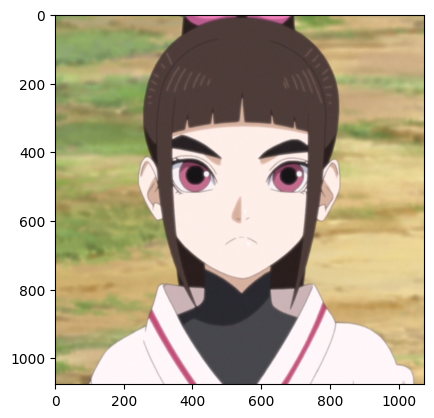

In [ ]:
plt.imshow(dataset['image'][999])

In [ ]:

def convert_images_to_jpeg_in_dataframe(df, image_column="image"):
    def convert_to_jpeg(image):
        if isinstance(image, Image.Image):  # Ensure it's a PIL image
            # Convert to RGB (JPEG does not support alpha channel)
            jpeg_image = image.convert("RGB")

            # Optionally, store the JPEG in memory as a BytesIO object
            buffer = io.BytesIO()
            jpeg_image.save(buffer, format="JPEG")
            buffer.seek(0)

            # Return the updated JPEG image as a PIL.Image object
            return Image.open(buffer)
        return image

    # Apply the conversion to the specified column
    df[image_column] = df[image_column].apply(convert_to_jpeg)
    return df

df = pd.DataFrame(dataset)

# Convert the images in the "image" column to JPEG
updated_df = convert_images_to_jpeg_in_dataframe(df, image_column="image")

print(updated_df)

                                                  image  \
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...   
...                                                 ...   
1216  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1217  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1218  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1219  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1220  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                 text  
0                 a man with dark hair and brown eyes  
1     a man in a hoodie with a fire in the background  
2             a man with a red hair and a black shirt  
3                  a man in a blue shirt and headband  
4          

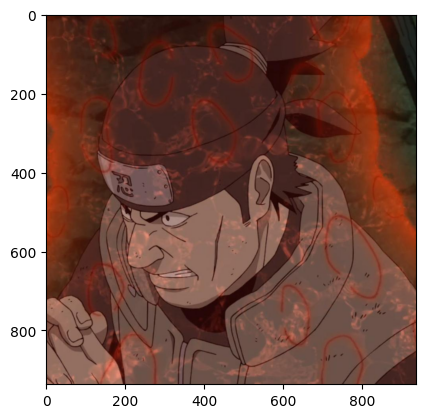

In [ ]:
plt.imshow(updated_df['image'][1])

In [ ]:
# prompt: i want to resize(512,512), turn each image to a tensor and normalize([0.5], [0.5]) for every item in updated_df['image'] according to its image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# Apply transformations to each image in the DataFrame
updated_df['processed_image'] = updated_df['image'].apply(lambda x: transform(x))
print(type(updated_df["processed_image"][0]),updated_df["processed_image"][0].shape)

<class 'torch.Tensor'> torch.Size([3, 512, 512])


In [ ]:
updated_df.head()

,image,text,processed_image
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,a man with dark hair and brown eyes,"[[[tensor(-0.7725), tensor(-0.7725), tensor(-0..."
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,a man in a hoodie with a fire in the background,"[[[tensor(-0.2941), tensor(-0.2941), tensor(-0..."
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,a man with a red hair and a black shirt,"[[[tensor(-0.7333), tensor(-0.7333), tensor(-0..."
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,a man in a blue shirt and headband,"[[[tensor(-0.1137), tensor(-0.1137), tensor(-0..."
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,a dog in a blue shirt laying on the ground,"[[[tensor(-0.3647), tensor(-0.3569), tensor(-0..."


In [ ]:
# prompt: how do i convert updated_df to a Dataset while only including the  updated_df['text'] and  updated_df['processed_image'] columns

# Create a new dictionary with the desired columns
dataset_dict = {
    'text': updated_df['text'].tolist(),
    'processed_image': updated_df['processed_image'].tolist()
}


In [ ]:
updated_dataset = Dataset.from_dict(dataset_dict)

In [ ]:
updated_dataset.set_format(type="torch")

In [ ]:
updated_dataset

Dataset({
    features: ['text', 'processed_image'],
    num_rows: 1221
})

In [ ]:
updated_dataset['text'][0]

'a man with dark hair and brown eyes'

In [ ]:
len(updated_dataset['processed_image'])

1221

The required shape of each image to tensor, **3**- R(red) G(greeen) B(blue) for each color, and then Height and Width- **512 x 512** pixels which is also fitted/adapted to be fed through the Unet. While the image is first fed through the VAE which its compressed to a latent vector 4x64x64. Each 3x8x8 pixel volume in the input image gets compressed down to just 4 numbers(4x1x1). You can find AEs with a higher compression ratio (eg f16 like some popular VQGAN models) but at some point they begin to introduce artifacts that we don't want.

In [ ]:
updated_dataset['processed_image'][0].shape

torch.Size([3, 512, 512])

Example of encoding and text embedding(without max padding or postional embedding)

In [ ]:
input_ids = tokenizer([updated_dataset['text'][0]])["input_ids"]
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = text_encoder(input_ids)["last_hidden_state"]
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
786 -> man
593 -> with
3144 -> dark
2225 -> hair
537 -> and
2866 -> brown
3095 -> eyes
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 10, 768])


Tokenization(embeding is applied in the training loop)

The required shape of the embeddings for each text/prompt: 1/4- batch, 77- number of tokens and 768- embedding size.

In [ ]:
updated_dataset['text'][0].shape

torch.Size([1, 77, 768])

In [ ]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [ ]:
# @title טיוטה
#updated_df['image'] = updated_df['image'].apply(to_numpy())
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_images(examples):
    examples["image"] = [preprocess(img) for img in [examples["image"]]]
    return examples

dataset = dataset.map(preprocess_images)

# @title Default title text
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
for i in range(len(dataset['image'])):
    dataset['image'][i] = preprocess(dataset['image'][i])
#dataset['image'] = preprocess(dataset['image'])
def preprocess_images(examples):
    examples["pixel_values"] = [preprocess(img) for img in [examples["image"]]]
    return examples

#dataset = dataset.map(preprocess_images)
#dataset.set_transform(preprocess_images)

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
def tokenize_and_embed(text):
    input_ids = tokenizer([text], padding="max_length", return_tensors="pt", truncation=True, max_length=77)["input_ids"]
    # input_ids = input_ids.clone().detach().to(device)
    # with torch.no_grad():
    #     text_embeddings = text_encoder(input_ids)["last_hidden_state"]
    return input_ids

updated_dataset = updated_dataset.map(lambda example: {'text': tokenize_and_embed(example['text'])}, batched=False)

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [ ]:
print(updated_dataset['text'][0].shape)
print(updated_dataset['text'][0])

torch.Size([1, 77])
tensor([[49406,   320,   786,   593,  3144,  2225,   537,  2866,  3095, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])


In [ ]:
with torch.no_grad():
    text_embeddings1 = text_encoder(updated_dataset['text'][0])["last_hidden_state"]
print(text_embeddings1.shape)
print(text_embeddings1)

torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.9929,  0.2396,  0.0260,  ..., -1.6722,  0.3606,  0.5111],
         ...,
         [-0.4119, -0.6959, -0.1655,  ..., -0.8969,  0.1838, -0.2633],
         [-0.4129, -0.7172, -0.1563,  ..., -0.8787,  0.1792, -0.2571],
         [-0.3478, -0.7255, -0.1227,  ..., -0.8928,  0.1933, -0.3340]]])


In [ ]:
with torch.no_grad():
    text_embeddings2 = text_encoder(updated_dataset['text'][0])[0]
print(text_embeddings2.shape)
print(text_embeddings2)

torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.9929,  0.2396,  0.0260,  ..., -1.6722,  0.3606,  0.5111],
         ...,
         [-0.4119, -0.6959, -0.1655,  ..., -0.8969,  0.1838, -0.2633],
         [-0.4129, -0.7172, -0.1563,  ..., -0.8787,  0.1792, -0.2571],
         [-0.3478, -0.7255, -0.1227,  ..., -0.8928,  0.1933, -0.3340]]])


#Model preparation and Training


In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('skip_prk_steps', True),
            ('set_alpha_to_one', False),
            ('prediction_type', 'epsilon'),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 1),
            ('_use_default_values', ['timestep_spacing', 'prediction_type']),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.6.0'),
            ('clip_sample', False)])

In [ ]:
summary(vae,(3,512,512), 4, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [4, 128, 512, 512]           3,584
         GroupNorm-2         [4, 128, 512, 512]             256
              SiLU-3         [4, 128, 512, 512]               0
              SiLU-4         [4, 128, 512, 512]               0
              SiLU-5         [4, 128, 512, 512]               0
              SiLU-6         [4, 128, 512, 512]               0
              SiLU-7         [4, 128, 512, 512]               0
              SiLU-8         [4, 128, 512, 512]               0
              SiLU-9         [4, 128, 512, 512]               0
             SiLU-10         [4, 128, 512, 512]               0
             SiLU-11         [4, 128, 512, 512]               0
             SiLU-12         [4, 128, 512, 512]               0
             SiLU-13         [4, 128, 512, 512]               0
             SiLU-14         [4, 128, 5

In [ ]:
summary(unet(), (3,512,512), 4, device='cuda'),

TypeError: UNet2DConditionModel.forward() missing 2 required positional arguments: 'timestep' and 'encoder_hidden_states'

In [ ]:
unet.num_parameters(only_trainable=True)

859520964

In [ ]:
epoches = 20
batch_size = 4
learning_rate = 5e-5

In [ ]:
accelerator = Accelerator()

In [ ]:
def collate_fn(batch):
    images = torch.stack([item["processed_image"] for item in batch])
    tokens = [item["text"] for item in batch]
    input_ids = tokenizer(tokens, padding="max_length", return_tensors="pt", truncation=True, max_length=77)["input_ids"]
    batch = {
        "input_ids": input_ids,
        "pixel_values": images,
    }
    return batch

In [ ]:
dataloader = DataLoader(updated_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Previewing batch:


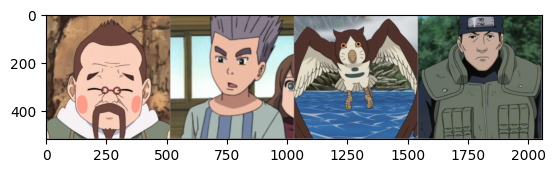

In [ ]:
print("Previewing batch:")
Batch = next(iter(dataloader))
grid = torchvision.utils.make_grid(Batch["pixel_values"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [ ]:
len(dataloader)

306

In [ ]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

In [ ]:
losses = []

progress_bar = tqdm(
      range(epoches), disable=not accelerator.is_local_main_process
    )
progress_bar.set_description("epoches")
global_step = 0

unet, optimizer, dataloader = accelerator.prepare(
        unet, optimizer, dataloader
    )

for epoch in range(epoches):  # Adjust number of epochs
    unet.train()
    for step, batch in enumerate(dataloader):
        with accelerator.accumulate(unet):
            with torch.no_grad():
                latents = vae.encode(batch['pixel_values'].cuda()).latent_dist.sample()
                latents = latents * 0.18215
            # print(latents.shape, latents.shape[0])

            # Apply scheduler noise
            noise = torch.randn(latents.shape).to(latents.device)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            # print(noisy_latents.shape, timesteps.shape,batch['input_ids'][step].shape)

            with torch.no_grad():
                encoder_hidden_states = text_encoder(batch["input_ids"].cuda())[0]

            # UNet Forward Pass
            outputs = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
            loss = (F.mse_loss(outputs, noise, reduction="none")
                  .mean([1, 2, 3])
                  .mean()
            )

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
        # if step % 100 == 0:

    if accelerator.sync_gradients:
      progress_bar.update(1)
      global_step += 1

    logs = {"loss": loss.detach().item()}
    progress_bar.set_postfix(**logs)

    losses.append(loss.detach().item())
    accelerator.wait_for_everyone()

    # Save after each epoch
    # unet.save_pretrained(f"{output_dir}/unet_epoch_{epoch}")

  0%|          | 0/20 [00:00<?, ?it/s]

Losses for every epoch(20). Each epoch = 305 steps

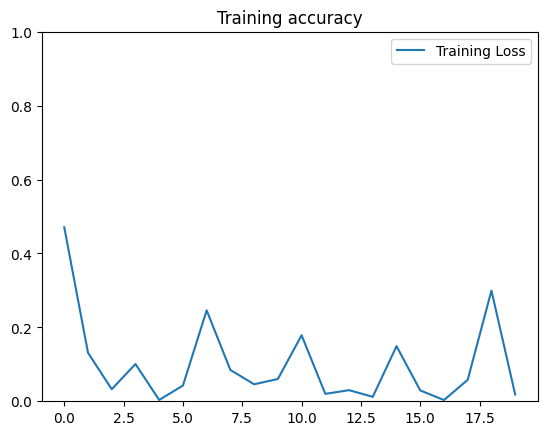

In [ ]:
# loss curve
epoches_ = range(len(losses))
plt.plot(epoches_, losses, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy')
plt.ylim(0, 1);
plt.show()

In [ ]:
losses2 = []

progress_bar = tqdm(
      range(len(dataloader)), disable=not accelerator.is_local_main_process
    )
progress_bar.set_description("steps")
global_step = 0

unet, optimizer, dataloader = accelerator.prepare(
        unet, optimizer, dataloader
    )

for epoch in range(1):  # Adjust number of epochs
    unet.train()
    for step, batch in enumerate(dataloader):
        with accelerator.accumulate(unet):
            with torch.no_grad():
                latents = vae.encode(batch['pixel_values'].cuda()).latent_dist.sample()
                latents = latents * 0.18215
            # print(latents.shape, latents.shape[0])

            # Apply scheduler noise
            noise = torch.randn(latents.shape).to(latents.device)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            # print(noisy_latents.shape, timesteps.shape,batch['input_ids'][step].shape)

            with torch.no_grad():
                encoder_hidden_states = text_encoder(batch["input_ids"].cuda())[0]

            # UNet Forward Pass
            outputs = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
            loss = (F.mse_loss(outputs, noise, reduction="none")
                  .mean([1, 2, 3])
                  .mean()
            )

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

            if accelerator.sync_gradients:
              progress_bar.update(1)
              global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            losses2.append(loss.detach().item())

    accelerator.wait_for_everyone()

  0%|          | 0/306 [00:00<?, ?it/s]

Losses for 1 whole epoch(306 steps).

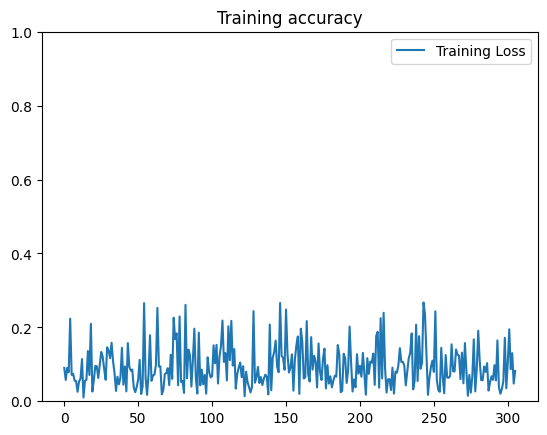

In [ ]:
# loss curve
epoches_ = range(len(losses2))
plt.plot(epoches_, losses2, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy')
plt.ylim(0, 1);
plt.show()

Saving the final model for the updated weights

In [ ]:
unet.save_pretrained(f"{output_dir}/final_unet")

# Vizualizing

There isnt any possible way to do a preformance evaluating so we will just create images based on prompts and decide if the generated image fits the prompt